# EDA
Let's analyze how goalies are affected after not seeing a shot in a while
* Does save percentage decrease?
* Does expected goals increase?

In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

##### Read in data

In [2]:
year = '2019'
path = '../../nhl_overtime_eda/data/' + year + '_regSeasonPlays.json'

games = {}
with open(path) as f:
    games[year] = json.load(f)

home_team
away_team
events


In [7]:
# year = '2020'
# years = ['2015','2016','2017','2018','2019','2020']
years = ['2019']
games = {}
for year in years:
    path = '../../nhl_overtime_eda/data/' + year + '_regSeasonPlays.json'
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

../../nhl_overtime_eda/data/2019_regSeasonPlays.json


In [8]:
# g = games['2019']['2019020001']

# get game data for 2019-20
game_data = games['2019']

In [9]:
# for game_id in game_data:
#     events = game_data[game_id]
#     break
    
# for event in events['events']:
#     print(event.get('result').get('strength').get('name'))

In [11]:
# for key in games['2019']['2019020001']:
#     print(key)
#     print(games['2019']['2019020001'][key])

In [25]:
# for i in games['2019']['2019020001']['events']:
#     pprint.pprint(i)

##### Data mining

In [26]:
# get information we care about: shots and goals
shots = []
for game_id in game_data:
    for event in game_data[game_id]['events']:
        # if event is shot or goal, save it
        if event['result']['event'] == 'Shot' or event['result']['event'] == 'Goal':
            shooter = ''
            shooter_id = 0
            goalie = ''
            goalie_id = 0

            # extract shooter/goalie
            for player in event['players']:
                if player['playerType'] == 'Shooter' or player['playerType'] == 'Scorer':
                    shooter = player['player']['fullName']
                    shooter_id = player['player']['id']
                elif player['playerType'] == 'Goalie':
                    goalie = player['player']['fullName']
                    goalie_id = player['player']['id']

            # extract strength for goal
            strength = 'unknown'
            try:
                strength = event['result']['strength']['name']
            except:
                pass

            shots.append({
                'game_id': game_id,
                'dateTime': event['about']['dateTime'],
                'period': event['about']['period'],
                'periodTime': event['about']['periodTime'],
                'x_loc': event['coordinates'].get('x', np.NaN),
                'y_loc': event['coordinates'].get('y', np.NaN),
                'shooter': shooter,
                'shooter_id': shooter_id,
                'goalie': goalie,
                'goalie_id': goalie_id,
                'is_goal': (event['result']['event'] == 'Goal'),
                'shot_type': event['result'].get('secondaryType'),                
                'strength': strength
            })


##### Feature engineering
* time since last shot (real time and time in period) **records of actual time are inaccurate
* zone where shot came from (high slot, upper slot, etc)
* change of angle since last shot
* change in distance since last shot
* days rest for goaltender
* characteristics of shooter/goalie
    * handness
    * height
    * weight
    * age

In [114]:
# convert to dataframe
df = pd.DataFrame(shots)
df = df[df['goalie'] != ''] # filter empty net goals
df = df[df['period'] != 5] # filter shootout attempts


# find total seconds between shots (periodTime)
df['time_seconds'] = df['periodTime'].str[:2].astype(int) * 60 + df['periodTime'].str[3:].astype(int)
df['time_seconds'] = np.where(df['period'] == 2, df['time_seconds'] + 1200, 
                                 np.where(df['period'] == 3, df['time_seconds'] + 2400, df['time_seconds']))
df = df.sort_values(by=['game_id', 'goalie', 'time_seconds']) # sort by game_id and goalie name
df['time_seconds_diff'] = df.groupby(['game_id', 'goalie'])['time_seconds'].diff(1).fillna(df['time_seconds'])

# get total shots
df['tot_shots'] = 1
df['tot_shots'] = df.groupby(['game_id', 'goalie'])['tot_shots'].cumsum()

# fix all shots to one side of ice (adjust x and y coordinates)
df.loc[df['x_loc'] < 0, 'y_loc'] = df['y_loc'] * -1
df['x_loc'] = df['x_loc'].abs()
df = df[df['x_loc'].notna()]

# calculate angle of shot compared to goal
x_goal = 89
df['shot_angle'] = np.where(df['x_loc'] != x_goal,
                            # when shot is from behind the net
                            np.where(df['x_loc'] > x_goal,
                                     np.where(df['y_loc'] >= 0,
                                              round(90 + (90 - np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2),
                                              round(-90 - (90 + np.arctan(df['y_loc'] / (df['x_loc'] - x_goal)) * (180 / np.pi)), 2)
                                             ),
                                     # when shot is in front of net
                                     round(np.arctan(df['y_loc'] / (x_goal - df['x_loc'])) * (180 / np.pi), 2)
                                    ),
                            # when shot is taken on the goal line
                            np.where(df['y_loc'] >= 0, 90, -90)
                           )

# calculate difference in shot angle
df['shot_angle_prev'] = df.groupby(['game_id', 'goalie'])['shot_angle'].shift(1).fillna(0)
df['shot_angle_diff'] = np.absolute(np.where(df['shot_angle'] < df['shot_angle_prev'],
                                                df['shot_angle'] - df['shot_angle_prev'],
                                                df['shot_angle_prev'] - df['shot_angle']
                                            )
                                   )

# determine if goalie moved to his right since last shot to attempt to make save
df['goalie_move_right'] = np.where(df['shot_angle'] > df['shot_angle_prev'], True, False)

# calculate shot distance to goal
df['shot_dist'] = round(np.sqrt(np.square(df['x_loc'] - x_goal) + np.square(df['y_loc'])), 2)
df['shot_dist_prev'] = df.groupby(['game_id', 'goalie'])['shot_dist'].shift(1).fillna(0)
df['shot_dist_diff'] = df['shot_dist'] - df['shot_dist_prev']

# get days rest for goalie (if at begining of season, just mark days rest as 5)
df_goalies = df[['game_id', 'goalie', 'dateTime']].groupby(['goalie', 'game_id']).first()
df_goalies['dateTime_prev'] = df_goalies['dateTime'].shift(1).fillna('1970-01-01T04:00:00Z')
df_goalies['goalie_days_rest'] = (pd.to_datetime(df_goalies['dateTime']) - pd.to_datetime(df_goalies['dateTime_prev'])).dt.round(freq='D').dt.days
df_goalies['goalie_days_rest'] = np.where(df_goalies['goalie_days_rest'] > 200, 
                                          5, 
                                          np.where(df_goalies['goalie_days_rest'] < 0,
                                                   5,
                                                   df_goalies['goalie_days_rest']
                                                  )
                                         )
df = df.sort_values(by=['goalie', 'game_id']).merge(df_goalies[['goalie_days_rest']], how='left', on=['goalie', 'game_id'])

# get player characteristics (age, height, weight, handness) and merge with dataframe
## retr
with open('../data/playerAttributes.json') as f:
    attributes = json.load(f)          # read file
df_atr = pd.DataFrame(attributes)      # convert to df
df_atr.sort_values('id', inplace=True) # sort by id

# merge skater attrs
df_atr_skaters = df_atr[(df_atr['type']=='Forward') | (df_atr['type']=='Defenseman')]    # filter by skaters
df_atr_skaters.columns = [f'shooter_{c}' for c in list(df_atr.columns)]                  # rename columns
df = df.sort_values('shooter_id').merge(df_atr_skaters, how='left', on='shooter_id')     # merge 
df['shooter_age'] = round((pd.to_datetime(df['dateTime'].str[:10]) - 
                           pd.to_datetime(df['shooter_birthDate'])).dt.days / 365, 1)      # calculate age

# merge goalie attrs
df_atr_goalies = df_atr[df_atr['type']=='Goalie']                                   # filter by goalies
df_atr_goalies.columns = [f'goalie_{c}' for c in list(df_atr.columns)]              # rename columns
df = df.sort_values('goalie_id').merge(df_atr_goalies, how='left', on='goalie_id')  # merge 
df['goalie_age'] = round((pd.to_datetime(df['dateTime'].str[:10]) - 
                          pd.to_datetime(df['goalie_birthDate'])).dt.days / 365, 1) # calculate age

df.head()


,game_id,dateTime,period,periodTime,x_loc,y_loc,shooter,shooter_id,goalie,goalie_id,...,shooter_age,goalie_fullName,goalie_birthDate,goalie_nationality,goalie_height,goalie_weight,goalie_shootsCatches,goalie_primaryPosition,goalie_type,goalie_age
0,2019020304,2019-11-17T00:46:36Z,1,12:17,84.0,18.0,Sam Reinhart,8477933,Craig Anderson,8467950,...,24.0,Craig Anderson,1981-05-21,USA,74,185,L,G,Goalie,38.5
1,2019020575,2019-12-24T02:10:16Z,2,19:36,73.0,-32.0,Evan Rodrigues,8478542,Craig Anderson,8467950,...,26.4,Craig Anderson,1981-05-21,USA,74,185,L,G,Goalie,38.6
2,2019020922,2020-02-19T03:02:55Z,3,02:57,60.0,14.0,Evan Rodrigues,8478542,Craig Anderson,8467950,...,26.6,Craig Anderson,1981-05-21,USA,74,185,L,G,Goalie,38.8
3,2019021022,2020-03-04T01:40:34Z,2,17:33,72.0,-19.0,Evan Rodrigues,8478542,Craig Anderson,8467950,...,26.6,Craig Anderson,1981-05-21,USA,74,185,L,G,Goalie,38.8
4,2019020575,2019-12-24T02:33:31Z,3,02:10,83.0,-22.0,Evan Rodrigues,8478542,Craig Anderson,8467950,...,26.4,Craig Anderson,1981-05-21,USA,74,185,L,G,Goalie,38.6


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67650 entries, 0 to 67649
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  67650 non-null  object 
 1   dateTime                 67650 non-null  object 
 2   period                   67650 non-null  int64  
 3   periodTime               67650 non-null  object 
 4   x_loc                    67650 non-null  float64
 5   y_loc                    67650 non-null  float64
 6   shooter                  67650 non-null  object 
 7   shooter_id               67650 non-null  int64  
 8   goalie                   67650 non-null  object 
 9   goalie_id                67650 non-null  int64  
 10  is_goal                  67650 non-null  bool   
 11  shot_type                67646 non-null  object 
 12  strength                 67650 non-null  object 
 13  time_seconds             67650 non-null  int64  
 14  time_seconds_diff     

In [117]:
cols_to_drop = ['dateTime', 'periodTime', 'strength',
                'shot_angle_prev', 'shot_dist_prev',
                'shooter_fullName', 'shooter_birthDate',
                'goalie_fullName', 'goalie_birthDate', 'goalie_primaryPosition', 'goalie_type']

df_tmp = df.drop(cols_to_drop, axis=1)

In [118]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67650 entries, 0 to 67649
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  67650 non-null  object 
 1   period                   67650 non-null  int64  
 2   x_loc                    67650 non-null  float64
 3   y_loc                    67650 non-null  float64
 4   shooter                  67650 non-null  object 
 5   shooter_id               67650 non-null  int64  
 6   goalie                   67650 non-null  object 
 7   goalie_id                67650 non-null  int64  
 8   is_goal                  67650 non-null  bool   
 9   shot_type                67646 non-null  object 
 10  time_seconds             67650 non-null  int64  
 11  time_seconds_diff        67650 non-null  float64
 12  tot_shots                67650 non-null  int64  
 13  shot_angle               67650 non-null  float64
 14  shot_angle_diff       

##### EDA

In [29]:
df_tmp = df[df['goalie']=='Frederik Andersen']
game_ids = df_tmp['game_id'].unique().tolist()[0:5] # get list of five games

Timeline of shots faced vs goals scored

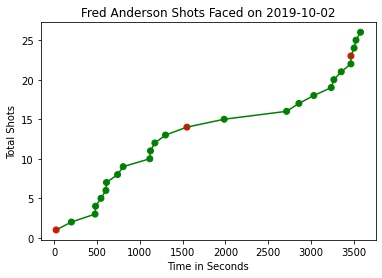

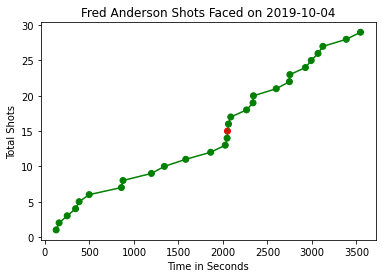

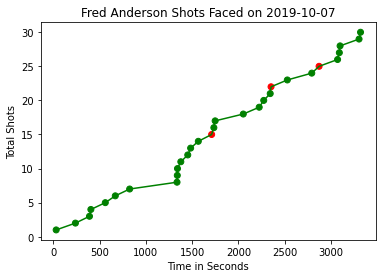

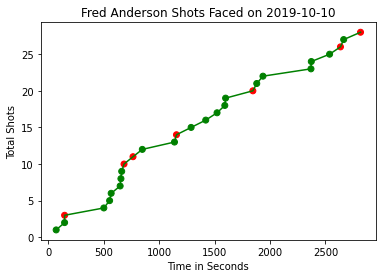

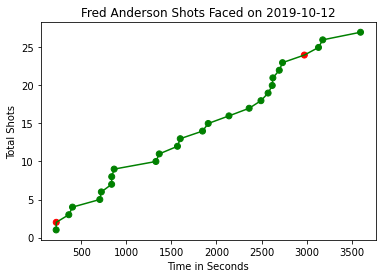

In [30]:
for game_id in game_ids:
    df_tmp2 = df_tmp[df_tmp['game_id']==game_id]
    date = df_tmp2['dateTime'].iloc[0][0:10]
    color = ['red' if goal else 'green' for goal in df_tmp2['is_goal'] ]

    plt.scatter(df_tmp2['time_seconds'], df_tmp2['tot_shots'], c=color)
    plt.plot(df_tmp2['time_seconds'], df_tmp2['tot_shots'], color='green')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("Time in Seconds")
    plt.ylabel("Total Shots")
    plt.show()


Scatter plot of shot locations

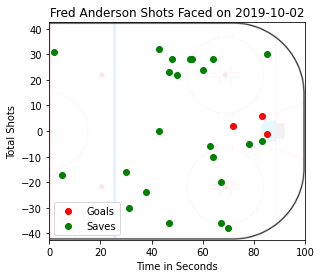

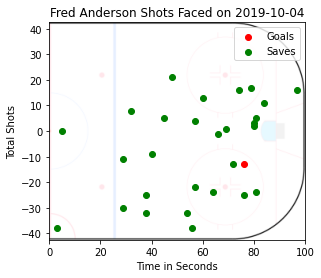

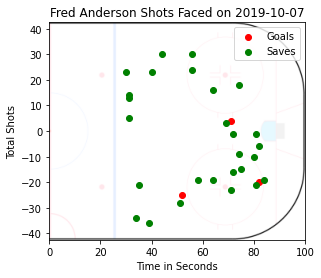

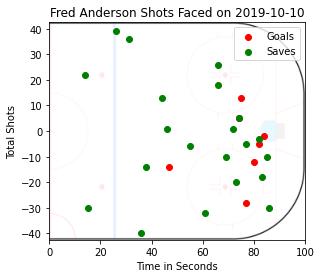

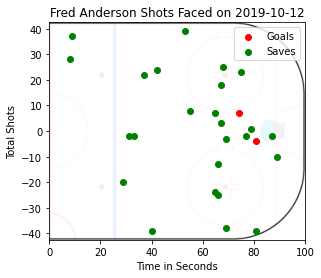

In [31]:
for game_id in game_ids:
    df_tmp2 = df_tmp[df_tmp['game_id']==game_id]
    date = df_tmp2['dateTime'].iloc[0][0:10]

    # read img (retrieved from https://thewincolumn.ca/2021/01/15/r-tutorial-creating-an-nhl-rink-using-the-tidyverse/)
    img = plt.imread("../data/images/nhl_rink_plot_output_light.png")
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[0, 100, -42.5, 42.5])

    # plot
    goals = plt.scatter(df_tmp2[df_tmp2['is_goal']==True]['x_loc'], 
                        df_tmp2[df_tmp2['is_goal']==True]['y_loc'], 
                        c='red', 
                        label='Goals')
    non_goals = plt.scatter(df_tmp2[df_tmp2['is_goal']==False]['x_loc'], 
                            df_tmp2[df_tmp2['is_goal']==False]['y_loc'], 
                            c='green', 
                            label='Saves')
    plt.title(f'Fred Anderson Shots Faced on {date}')
    plt.xlabel("Time in Seconds")
    plt.ylabel("Total Shots")
    ax.legend()
    plt.show()

Change in angle of rebound vs Shot outcome

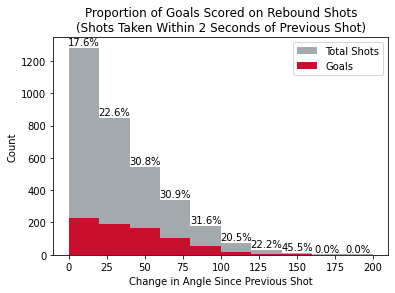

In [32]:
df_rebounds = df[df['time_seconds_diff'] <= 2].copy() # get shots with previous shot taken in past 3 seconds
df_rebounds = df_rebounds[df_rebounds['goalie'] != ''] # filter empty netters

fig, ax = plt.subplots()

bins = list(np.linspace(0,200,11))
non_goals = plt.hist(df_rebounds['shot_angle_diff'],
                        color='#A2AAAD',
                        label='Total Shots',
                        bins=bins)
goals = plt.hist(df_rebounds[df_rebounds['is_goal'] == True]['shot_angle_diff'],
                color='#C8102E',
                label='Goals',
                bins=bins)

plt.title('Proportion of Goals Scored on Rebound Shots\n(Shots Taken Within 2 Seconds of Previous Shot)')
plt.xlabel("Change in Angle Since Previous Shot")
plt.ylabel("Count")
ax.legend()

# create labels
rects = ax.patches
labels = []
for i in range(len(goals[0])):
    labels.append(round(goals[0][i] / non_goals[0][i] * 100,1))


# apply labels
for rect, label in zip(rects, labels):
    height = rect.get_height()
    text_color = 'black'
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
    
plt.show()